In [1]:
import random

from tqdm.auto import tqdm
from transformers import RobertaTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import RobertaTokenizer, RobertaModel
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tqdm.pandas()

2024-04-08 17:57:51.706966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 17:57:51.707061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 17:57:51.875156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/roberta-base/rust_model.ot
/kaggle/input/roberta-base/config.json
/kaggle/input/roberta-base/merges.txt
/kaggle/input/roberta-base/README.md
/kaggle/input/roberta-base/tokenizer.json
/kaggle/input/roberta-base/vocab.json
/kaggle/input/roberta-base/tf_model.h5
/kaggle/input/roberta-base/dict.txt
/kaggle/input/roberta-base/pytorch_model.bin
/kaggle/input/roberta-base/flax_model.msgpack
/kaggle/input/my-dataset/Extra-Datasets-Used/sample_submission.csv
/kaggle/input/my-dataset/Extra-Datasets-Used/saved_model.pb
/kaggle/input/my-dataset/Extra-Datasets-Used/llama_70b_v1.csv
/kaggle/input/my-dataset/Extra-Datasets-Used/test_essays.csv
/kaggle/input/my-dataset/Extra-Datasets-Used/

In [3]:
SEED = 42
# Setting seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Additional settings for PyTorch
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # for multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_data = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
test_data = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

# train_data = train_data.sample(frac=0.01, random_state=42)

In [5]:
train_essay = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/train_essays.csv")
test_essay = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/test_essays.csv")
ai_df = train_essay[train_essay['generated']==1]
df = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/Training_Essay_Data.csv")

In [6]:
df2 = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/train_drcat_04.csv")
df2 = df2[['text','label']]
df2.columns = ['text','generated']

In [9]:
df3 = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/train_essays_RDizzl3_seven_v1.csv")
df3.columns = ['text','generated']

In [10]:
train_data = pd.concat([df3,df2,df],axis=0,ignore_index=True)
train_data.drop_duplicates(inplace=True,ignore_index=True)

In [11]:
d1 = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/falcon_180b_v1.csv")
d2 = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/llama_70b_v1.csv")
data = pd.concat([d1,d2],axis=0,ignore_index=True)
data['generated'] = 1
data.columns = ['text','writing_prompt','generated']
data = data[['text','generated']]

In [12]:
Train_Data = pd.concat([train_data,data],axis=0,ignore_index=True)


In [13]:
d = pd.read_csv("/kaggle/input/my-dataset/Extra-Datasets-Used/LLM_generated_essay_PaLM.csv")
d['generated'] = d['generated'].astype(int)
dd = d[['text','generated']]

In [14]:
Train_Data  =pd.concat([Train_Data,dd],axis=0,ignore_index=True)
Train_Data.drop_duplicates(inplace=True,ignore_index=True)

In [15]:
def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()
    
    balanced_df=pd.DataFrame()
    
    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)
        
    return balanced_df

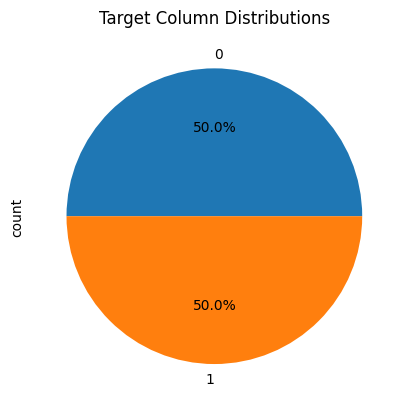

In [16]:
Train_Data=balance_labels(Train_Data)
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

In [17]:
%%time
train_data, test_data = train_test_split(Train_Data, test_size=0.2, random_state=42)

CPU times: user 17.9 ms, sys: 983 µs, total: 18.8 ms
Wall time: 17.9 ms


In [18]:
train_data.generated.value_counts()

generated
0    33029
1    32982
Name: count, dtype: int64

In [19]:
tokenizer = RobertaTokenizer.from_pretrained("/kaggle/input/roberta-base")

In [20]:
def tokenize_and_truncate(text, max_length=512):
    # Tokenize and truncate
    tokens = tokenizer.tokenize(text)[:max_length]  # leaving space for special tokens
    # Add the special tokens
    
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    return token_ids

In [21]:
train_data["tokens"] = train_data.text.progress_apply(lambda x: tokenize_and_truncate(x))

  0%|          | 0/66011 [00:00<?, ?it/s]

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
# Define your custom RoBERTa-based model
class RobertaForBinaryClassification(nn.Module):
    def __init__(self):
        super(RobertaForBinaryClassification, self).__init__()

        self.roberta = RobertaModel.from_pretrained("/kaggle/input/roberta-base")
        hidden_size = self.roberta.config.hidden_size

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        probs = self.sigmoid(logits)
        return probs
    
class TextDataset(Dataset):
    def __init__(self, token_lists, labels, max_token_len=512):
        self.token_lists = token_lists
        self.labels = labels
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        # Pad the token lists to the max length
        token_list = self.token_lists[idx][:self.max_token_len]  # truncate if longer than max length
        padded_tokens = token_list + [0] * (self.max_token_len - len(token_list))  # pad with zeros
        attention_mask = [1 if i < len(token_list) else 0 for i in range(self.max_token_len)]
        return torch.tensor(padded_tokens), torch.tensor(attention_mask), torch.tensor(self.labels[idx])

In [24]:
import gc
torch.cuda.empty_cache()
gc.collect()

18

In [25]:
# Create Dataset and DataLoader
dataset = TextDataset(train_data["tokens"].tolist(), train_data["generated"].tolist())
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model
model = RobertaForBinaryClassification()
model = nn.DataParallel(model)
model.to(device)

# Define loss function and optimizer
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [26]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, attention_masks, labels in tqdm(train_loader):
        tokens, attention_masks, labels = tokens.to(device), attention_masks.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        labels = labels.float().unsqueeze(1)  # Adjust labels' shape if necessary

        outputs = model(tokens, attention_mask=attention_masks)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

  0%|          | 0/2063 [00:00<?, ?it/s]

Epoch 1/1, Loss: 0.029284893808425035


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Put model in evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_predictions = []
all_labels = []

with torch.no_grad():
    for tokens, attention_masks, labels in tqdm(train_loader):
        tokens, attention_masks, labels = tokens.to(device), attention_masks.to(device), labels.to(device)

        # Run inference
        outputs = model(tokens, attention_mask=attention_masks)

        # Convert outputs to predictions (binary classification)
        predictions = (outputs > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Flatten the lists and convert to numpy arrays
all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels).flatten()

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Training Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

  0%|          | 0/2063 [00:00<?, ?it/s]

Training Accuracy: 99.79%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [28]:
test_data["tokens"] = test_data.text.progress_apply(lambda x: tokenize_and_truncate(x))

  0%|          | 0/16503 [00:00<?, ?it/s]

In [29]:
class TextDatasetTest(Dataset):
    def __init__(self, token_lists, max_token_len=512):
        self.token_lists = token_lists
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        # Pad the token lists to the max length
        token_list = self.token_lists[idx][:self.max_token_len]  # truncate if longer than max length
        padded_tokens = token_list + [0] * (self.max_token_len - len(token_list))  # pad with zeros
        attention_mask = [1 if i < len(token_list) else 0 for i in range(self.max_token_len)]
        return torch.tensor(padded_tokens), torch.tensor(attention_mask)

In [30]:
test_dataset = TextDatasetTest(test_data["tokens"].tolist())
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Put model in evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_outputs = []
with torch.no_grad():
    for tokens, attention_masks in tqdm(test_loader):
        tokens, attention_masks = tokens.to(device), attention_masks.to(device)

        # Run inference
        outputs = model(tokens, attention_mask=attention_masks)
        all_outputs.extend(outputs.cpu().numpy())
        # Convert outputs to predictions (binary classification)

# Flatten the lists and convert to numpy arrays
all_outputs = np.array(all_outputs).flatten()

  0%|          | 0/516 [00:00<?, ?it/s]

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Put model in evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_predictions = []
all_labels = test_data["generated"].tolist()  # Assuming "label" is the column containing ground truth labels

with torch.no_grad():
    for tokens, attention_masks in tqdm(test_loader):
        tokens, attention_masks = tokens.to(device), attention_masks.to(device)

        # Run inference
        outputs = model(tokens, attention_mask=attention_masks)

        # Convert outputs to predictions (binary classification)
        predictions = (outputs > 0.5).int()  # Apply threshold and convert to integers
        all_predictions.extend(predictions.cpu().numpy())

# Flatten the lists and convert to NumPy arrays
all_predictions = np.array(all_predictions).flatten()

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


  0%|          | 0/516 [00:00<?, ?it/s]

Testing Accuracy: 99.75%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [35]:
import pickle
with open('RoBERTa_model.pkl', 'wb') as f:
    pickle.dump(model, f)

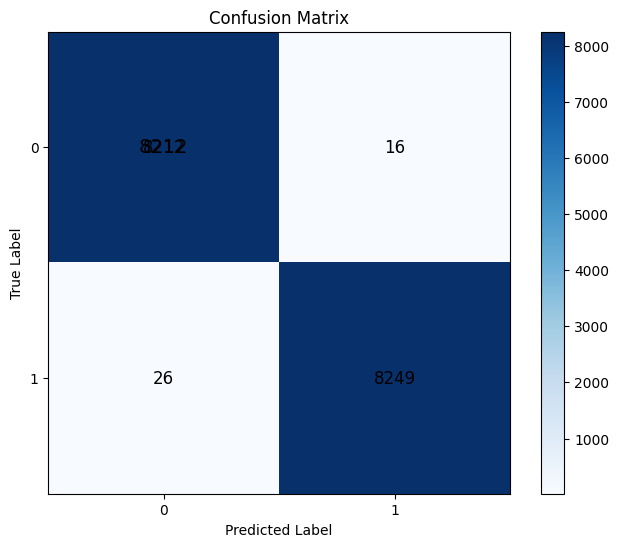

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(np.unique(all_labels))), np.unique(all_labels))
plt.yticks(np.arange(len(np.unique(all_labels))), np.unique(all_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(0, 0, cm[0, 0], va='center', ha='center', color='black', fontsize=14)
# Add text for other entries in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], va='center', ha='center', color='black', fontsize=12)
plt.grid(False)
plt.show()

In [ ]:
submission = pd.DataFrame({
    'id': test_data["id"],
    'generated': all_outputs
})
submission

In [ ]:
submission.to_csv("submission.csv", index=False)